In [1]:
import numpy as np
import torch.optim as optim
from torch.autograd import Variable
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt

## Synthetic experiment

**Clean labels as oracle.** I sample triplets $(x_i, z_i, y_i)$ from:

\begin{align*}
  x_i       &\sim \mathcal{N}(0,I_d)\\
  \varepsilon_i &\sim \mathcal{N}(0,1)\\
  z_i &\leftarrow \langle \alpha, x_i \rangle + \varepsilon_i\\ 
  y_i       &\leftarrow \mathbb{I}(z_i  > 0).
\end{align*}


In [2]:
def synthetic_01(a, n):
    """
    Data generating process as outlined above.
    
    :param a: design coefficients alpha 
    :param n: number of samples
    :return: (z, x, y)-tuple
    """
    x  = np.random.randn(n, a.size)
    e  = (np.random.randn(n))[:, np.newaxis]
    z = np.dot(x, a)[:, np.newaxis] + e
    #y  = ((z + e) > 0).ravel()
    y  = (z > 0).ravel()
    return (z, x, y)

In [3]:
# SimpleNN will serve us as linear and logistic regression (depending on the loss function)
class SimpleNN(nn.Module):
    def __init__(self, d, q):
        super(SimpleNN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(d, q),
        )

    def forward(self, x):
        return self.fc(x)

def fit_model(model, optimizer, criterion, epochs, x, y):
    for epoch in range(epochs):
        logits = model(x)
        loss = criterion(logits, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return model

In [4]:
def do_exp(x_tr, z_tr, y_tr, x_te, z_te, y_te):
    """
    Run experiment for two models:
    1. Classical model that fits f: x -> y
    2. z-augmented model that fits f: x -> z and then uses the structural knowledge to reconstruct y from z 
    
    :input: train data x_tr, z_tr, y_tr, x_te, z_te, y_te
    :return: np.array([res_xy, res_xz]) - accuracies of models 1 and 2
    """
    l_r=0.01
    epochs=1000

    y_tr = y_tr * 1.0
    y_te = y_te * 1.0
    y_tr = np.vstack((y_tr==1, y_tr==0)).T
    y_te = np.vstack((y_te==1, y_te==0)).T
    x_tr = Variable(torch.from_numpy(x_tr)).type(torch.FloatTensor)
    x_te = Variable(torch.from_numpy(x_te)).type(torch.FloatTensor)
    y_tr = Variable(torch.from_numpy(y_tr)).type(torch.FloatTensor)
    z_tr = Variable(torch.from_numpy(z_tr)).type(torch.FloatTensor)
    
    """
    Training of regular model x -> y
    """
    mlp_xy = SimpleNN(x_tr.shape[1], 2)
    optimizer = optim.SGD(mlp_xy.parameters(),lr=l_r)
    criterion = nn.CrossEntropyLoss()
    
    mlp_xy = fit_model(mlp_xy, optimizer, criterion, epochs, x_tr, y_tr)
    output = mlp_xy(x_te)
    pred = torch.argmax(output,dim=1)
    res_xy= np.mean(pred.numpy() == np.argmax(y_te, 1))

    """
    Training of z-augmented model x -> z and reconstructing y
    """
    mlp_xz = SimpleNN(x_tr.shape[1], 1)
    optimizer = optim.SGD(mlp_xz.parameters(), lr=l_r)
    criterion = torch.nn.MSELoss()
    
    mlp_xz = fit_model(mlp_xz, optimizer, criterion, epochs, x_tr, z_tr)
    output = mlp_xz(x_te)
    # here is where we use the knowledge y = I{z > 0}
    pred = torch.where(output.squeeze() > 0, 0, 1)
    res_xz = np.mean(pred.numpy() == np.argmax(y_te, 1))

    return np.array([res_xy, res_xz])

In [5]:
# experiment hyper-parameters
d      = 50   # num features
n_te   = 1000 # num test samples
n_reps = 30   # num repetitions

results = {}
print("Training_size\tx->y\tx->z")
mean_results = {
    "Training size": [],
    "x->y": [],
    "x->z": []
}
std_results = {
    "Training size": [],
    "x->y": [],
    "x->z": []
}

for n_tr in [200, 500, 1000, 2000, 5000]:
    np.random.seed(0)
    R = np.zeros((n_reps, 2))
    for rep in tqdm(range(n_reps)):
        # generate test and train data
        a = np.random.randn(50)
        (z_tr, x_tr, y_tr) = synthetic_01(a, n=n_tr)
        (z_te, x_te, y_te) = synthetic_01(a, n=n_te)
        # run experiment
        R[rep, :] += do_exp(x_tr, z_tr, y_tr, x_te, z_te, y_te)
    # store results
    means = R.mean(axis=0).round(2)
    stds  = R.std(axis=0).round(2)
    print(f"{n_tr}\t\t{means[0]}(+/-{stds[0]})\t{means[1]}(+/-{stds[1]})")
    
    mean_results["Training size"].append(n_tr)
    mean_results["x->y"].append(means[0])
    mean_results["x->z"].append(means[1])

    std_results["Training size"].append(n_tr)
    std_results["x->y"].append(stds[0])
    std_results["x->z"].append(stds[1])

Training_size	x->y	x->z


100%|██████████| 30/30 [00:04<00:00,  6.33it/s]


200		0.87(+/-0.02)	0.95(+/-0.01)


100%|██████████| 30/30 [00:04<00:00,  6.22it/s]


500		0.91(+/-0.02)	0.95(+/-0.01)


100%|██████████| 30/30 [00:05<00:00,  5.30it/s]


1000		0.93(+/-0.01)	0.95(+/-0.01)


100%|██████████| 30/30 [00:06<00:00,  4.29it/s]


2000		0.94(+/-0.01)	0.96(+/-0.01)


100%|██████████| 30/30 [00:11<00:00,  2.52it/s]

5000		0.95(+/-0.01)	0.96(+/-0.01)


<Figure size 1000x600 with 0 Axes>

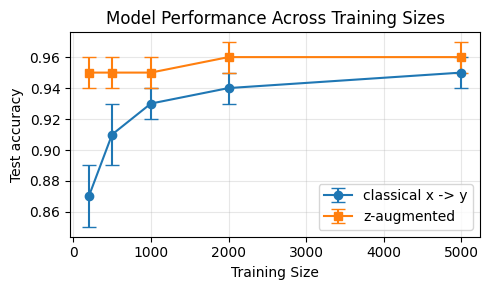

In [7]:
plt.figure(figsize=(10, 6))
train_sizes = mean_results['Training size']
model1_means = mean_results['x->y']
model2_means = mean_results['x->z']

model1_stds = std_results['x->y']
model2_stds = std_results['x->z']

plt.figure(figsize=(5, 3))
plt.errorbar(train_sizes, model1_means, yerr=model1_stds, fmt='-o', label='classical x -> y', capsize=5)
plt.errorbar(train_sizes, model2_means, yerr=model2_stds, fmt='-s', label='z-augmented', capsize=5)

plt.xlabel('Training Size')
plt.ylabel('Test accuracy')
plt.title('Model Performance Across Training Sizes')
plt.legend(loc='lower right')

plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('acc_vs_trainsize.png', bbox_inches='tight')
plt.show()
